# Breakout
description : https://gym.openai.com/envs/Breakout-v0/   
architecture : https://arxiv.org/pdf/1312.5602.pdf

In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from skimage.transform import resize

import renom as rm
from renom_rl.discrete.double_dqn import DoubleDQN
from renom_rl.environ import BaseEnv
from renom_rl.utility.filter import EpsilonEIFilter
from renom_rl.utility import Animation

from renom.cuda import set_cuda_active
set_cuda_active(True)

In [2]:
class Breakout(BaseEnv):
    
    def __init__(self):
        self.env = gym.make('BreakoutNoFrameskip-v4')
        self.action_shape = (self.env.action_space.n,)
        self.action_interval = 4
        self.state_shape = (self.action_interval, 84, 84)
        print("Env space : ", self.env.observation_space.shape)
        print("Preprocessed Env space : ", self.state_shape)
        print("Action space : ", self.action_shape)
        
        self.real_done = True
        self.lives = 0
        self.time_step = 0
        self.max_time_length = 5000
        
        self.animation = Animation(ratio=36.0)
        
    def reset(self):
        if self.real_done:
            obs = self.env.reset()
            n_step = np.random.randint(5)
            for _ in range(n_step):
                obs, _, _ = self.step(0)
        else:
            obs, _, _ = self.step(0)
        self.lives = self.env.unwrapped.ale.lives()
        return obs
    
    def sample(self):
        return self.env.action_space.sample()
    
   
    def _preprocess(self, state_list):
        processed_state_list = []
        for s in state_list:
            processed_state = np.uint8(resize(rgb2gray(s)*255, (84, 84)))
            processed_state_list.append(processed_state)
            
        
        if len(processed_state_list) is not self.action_interval:
            for _ in range(self.action_interval - len(processed_state_list)):
                processed_state_list.append(processed_state_list[-1])
        
        return np.array(processed_state_list)
        
    def step(self, action):
        state_list = []
        reward_list = []
        self.real_done = False
        self.time_step += 1
        
        for _ in range(self.action_interval):
            state, reward, terminal, _ = self.env.step(int(action))
            state_list.append(state)
            reward_list.append(reward)
            
            if terminal:
                self.real_done = True
                self.time_step = 0
                break
                
        processed_state = self._preprocess(state_list)
        
        lives = self.env.unwrapped.ale.lives()
        if lives < self.lives and lives > 0:
            terminal = True
            self.time_step = 0
        self.lives = lives
        
        if self.time_step > self.max_time_length:
            self.real_done = True
            terminal = True
            self.time_step = 0
        
        return processed_state, sum(reward_list), terminal
    
    def test_start(self):
        self.animation.reset()
        self.env.reset()
    
    def test_epoch_step(self):
        self.animation.store(self.env.render(mode="rgb_array"))
    
    def test_close(self):
        #self.env.close() 
        self.env.viewer = None
    
env = Breakout()
q_network = rm.Sequential([rm.Conv2d(16, filter=8, stride=4),
                           rm.Relu(),
                           rm.Conv2d(32, filter=4, stride=2),
                           rm.Relu(),
                           rm.Flatten(), 
                           rm.Dense(256),
                           rm.Relu(),
                           rm.Dense(env.action_shape[0])])

Env space :  (210, 160, 3)
Preprocessed Env space :  (4, 84, 84)
Action space :  (4,)


In [3]:
fil = EpsilonEIFilter(min=0.1,max=1.0, initial=1.0, alpha=0.005)

agent = DoubleDQN(env, q_network)
agent.fit(epoch=1,
          epoch_step=50000,
          update_period=100,
          batch_size=32,
          random_step=200,
          action_filter=fil,
          test_step=None)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Run random 200 step for storing experiences


epoch 001 avg_loss:0.8329 total reward in epoch: [train:606.000 test: 2.0] avg train reward in episode:0.492 e-greedy:0.226: 100%|██████████| 50000/50000 [15:05<00:00, 78.91it/s]


reward of one episode is 2.0
length of animationb:  102



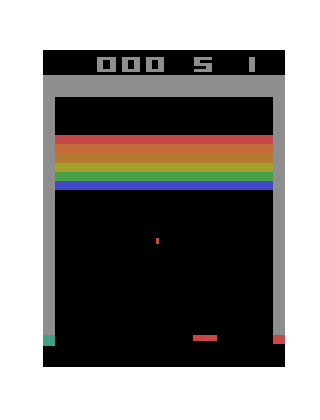
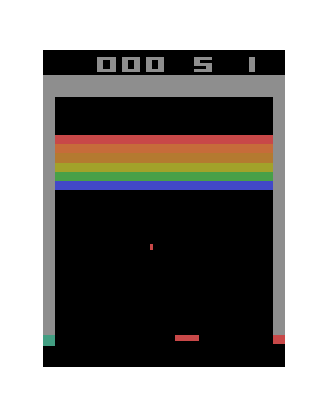
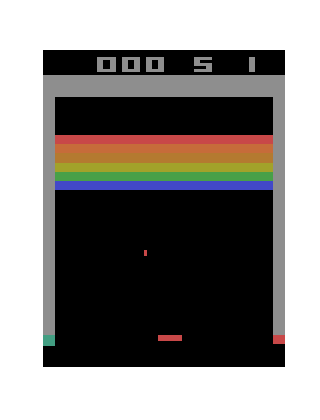
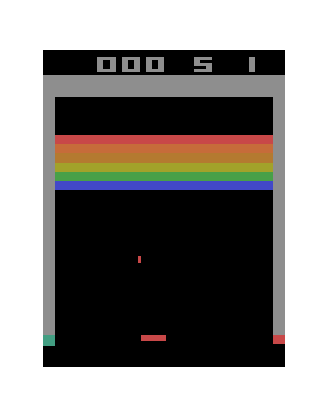
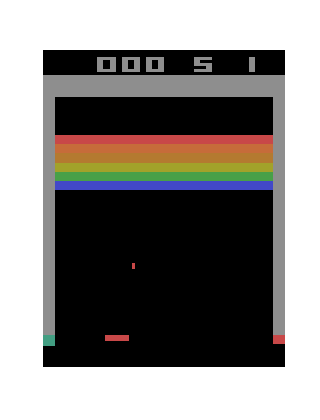
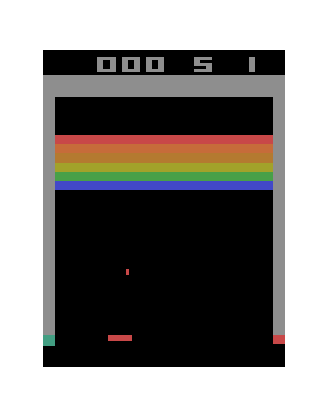
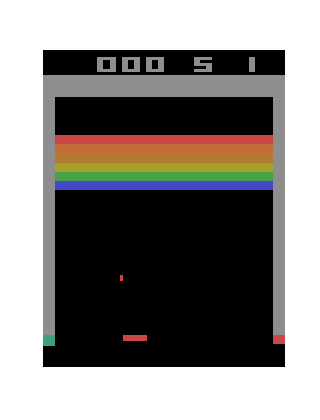
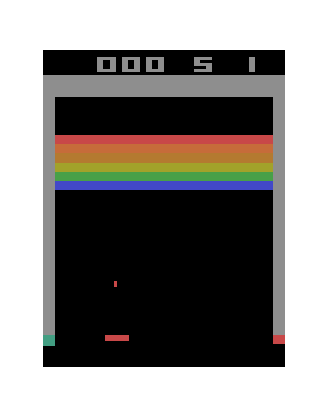
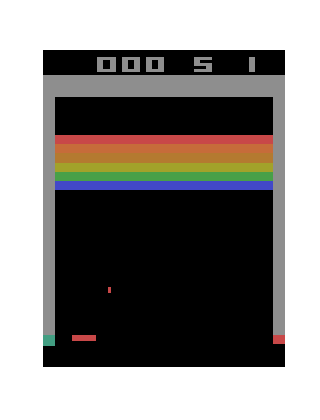
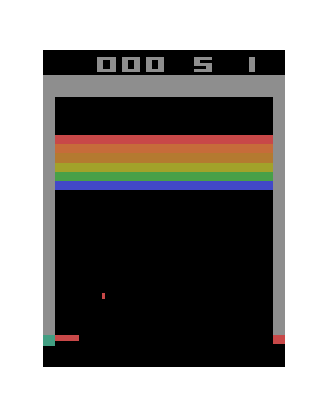
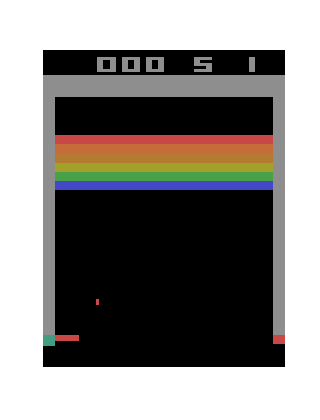
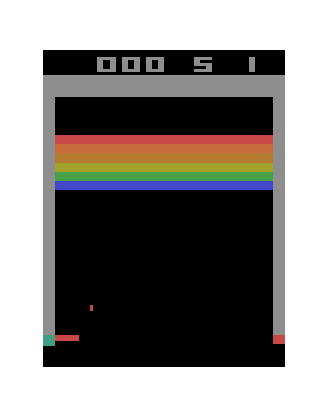
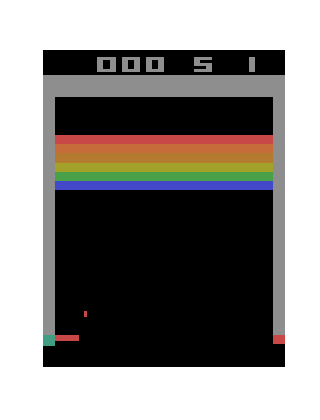
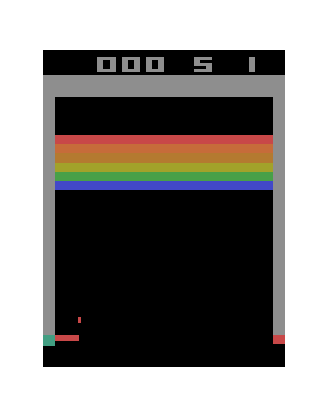
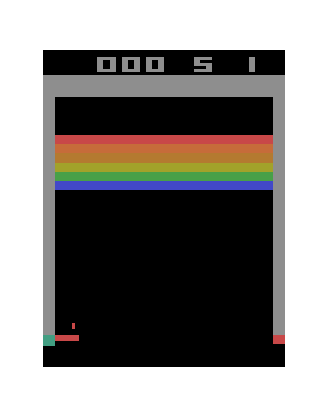
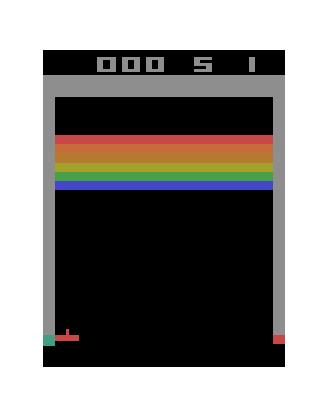
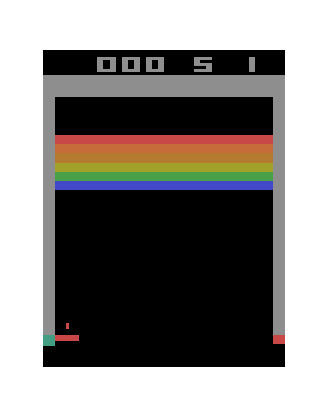
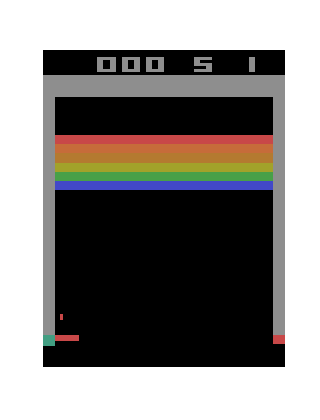
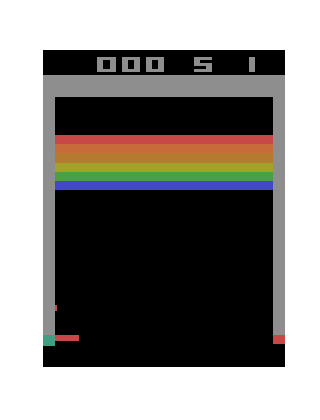
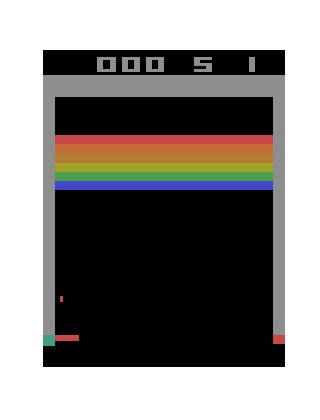
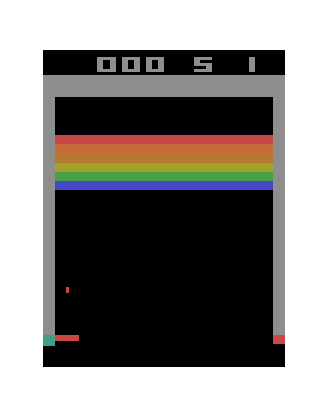
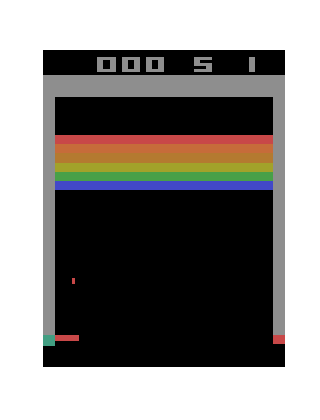
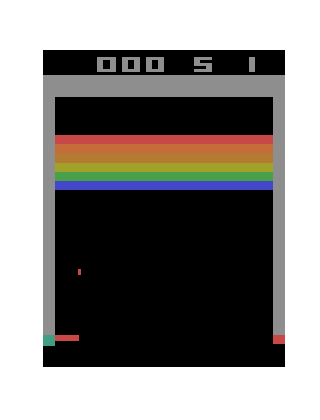
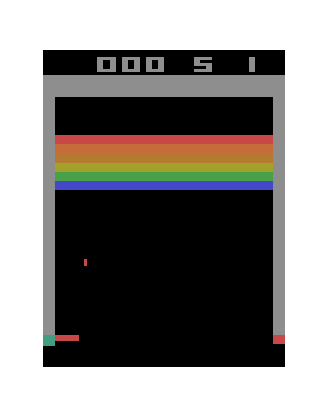
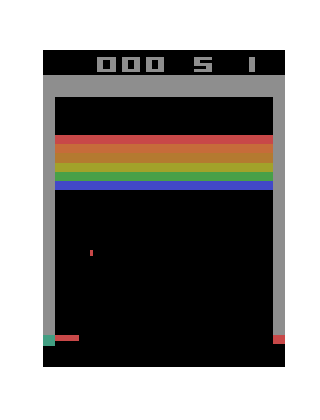
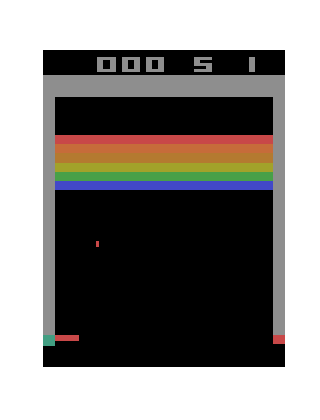
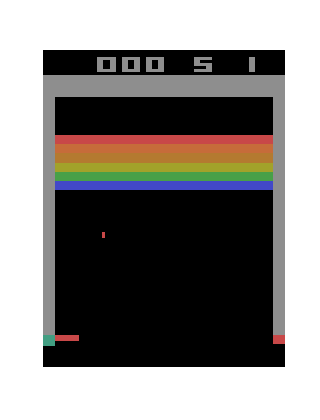
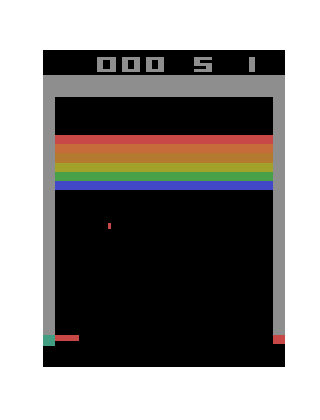
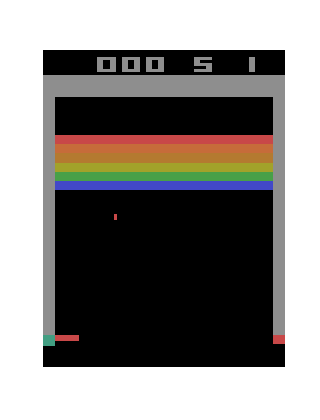
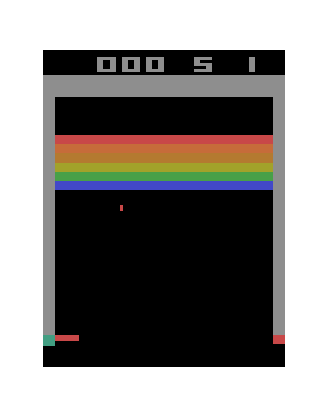
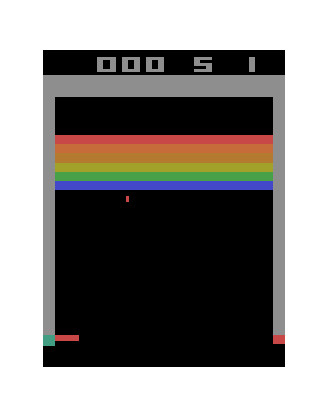
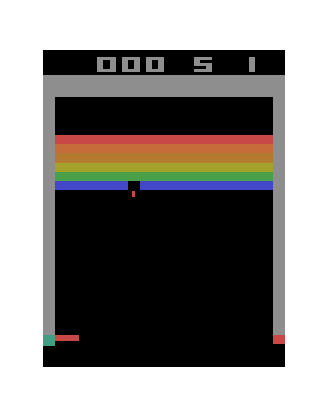
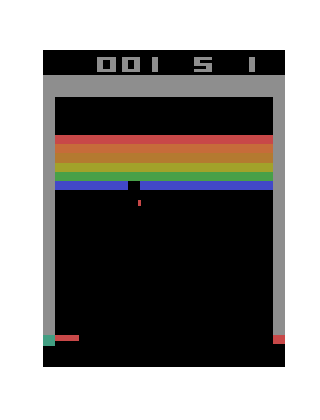
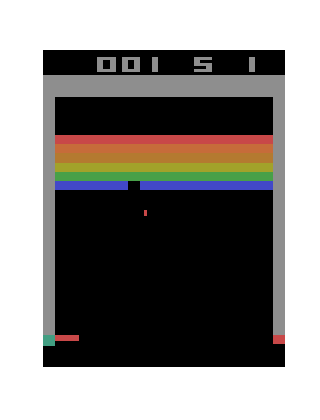
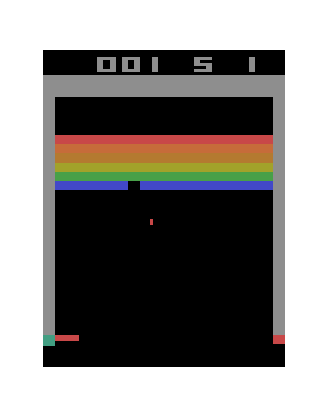
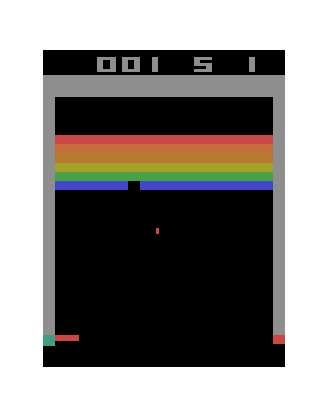
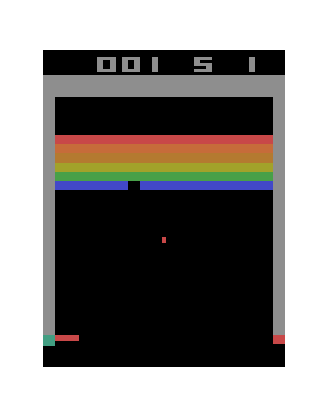
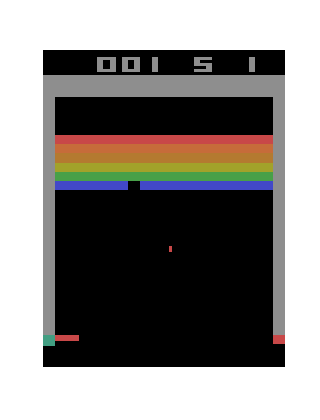
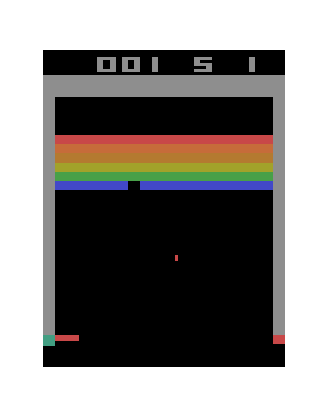
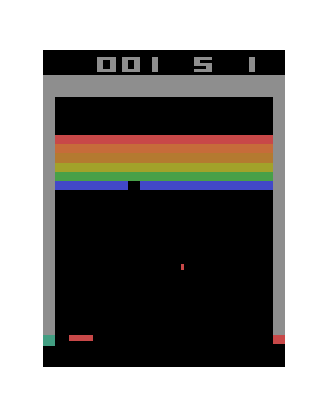
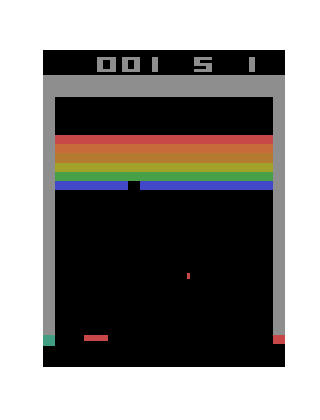
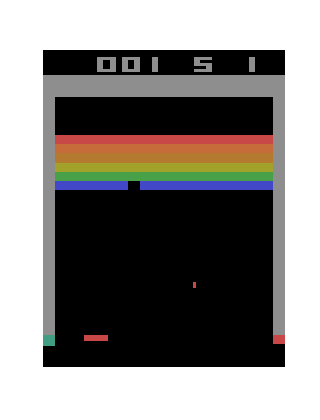
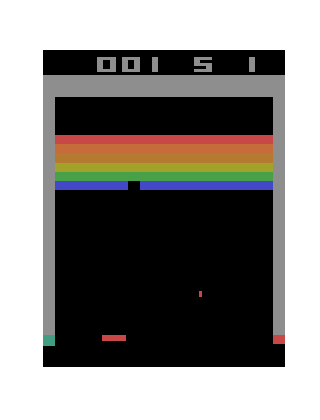
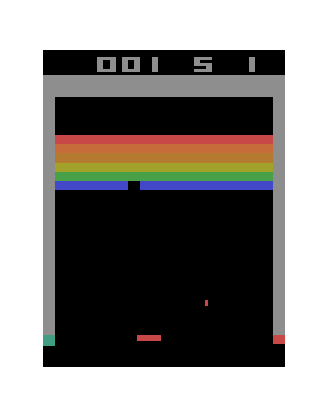
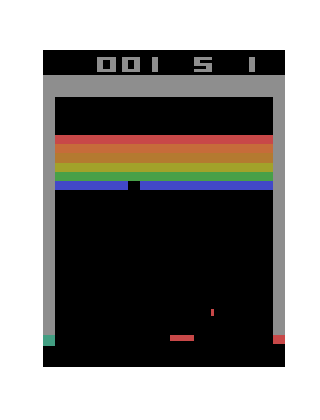
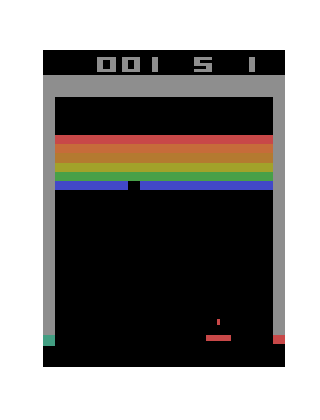
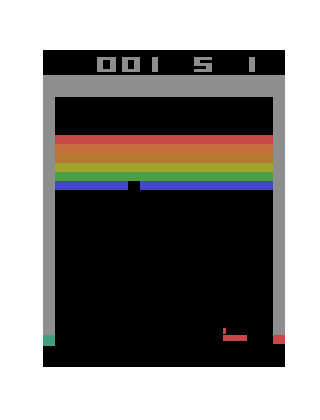
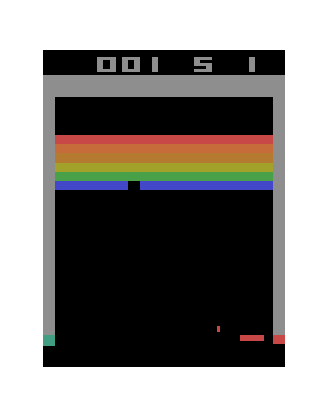
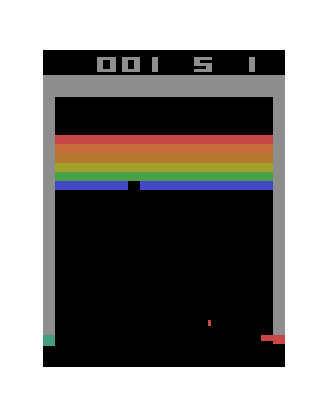
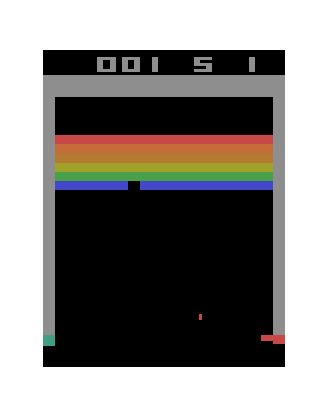
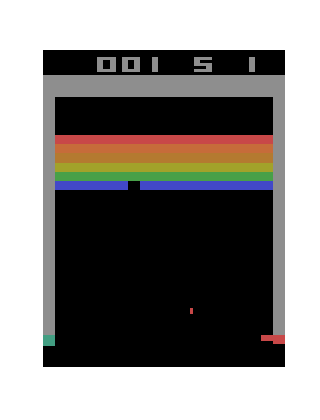
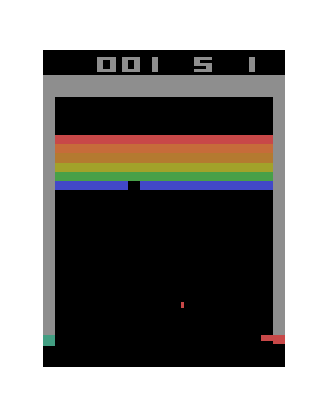
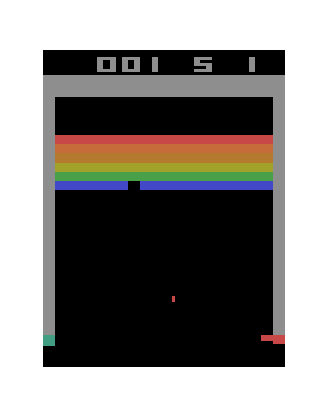
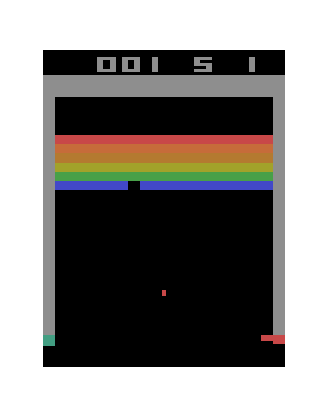
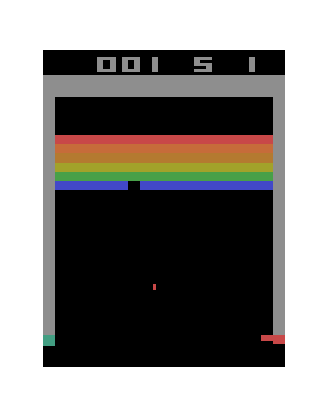
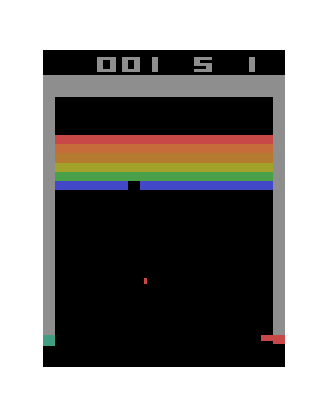
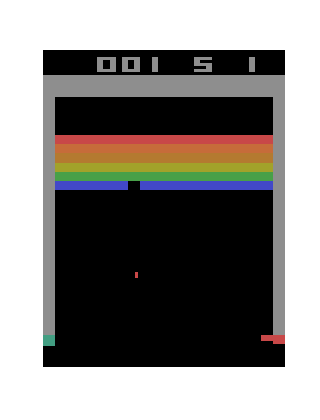
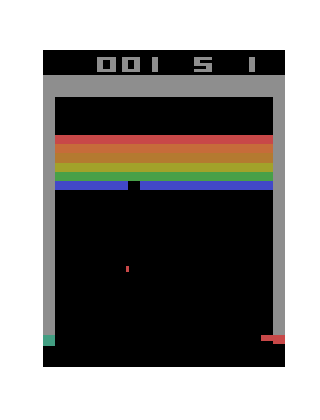
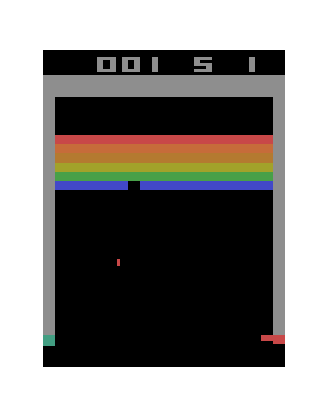
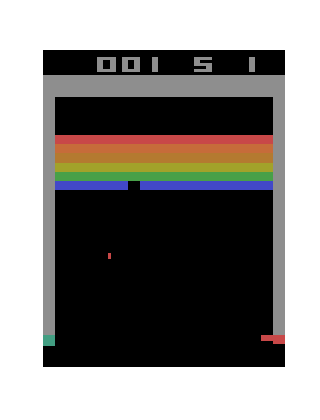
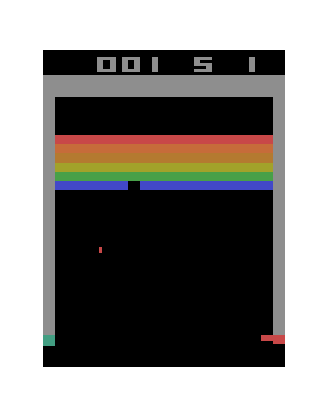
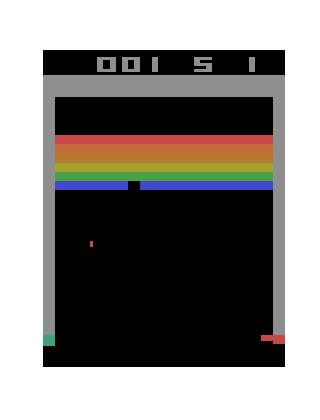
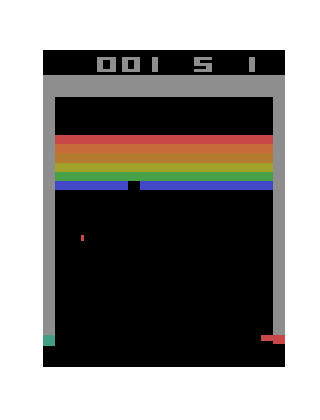
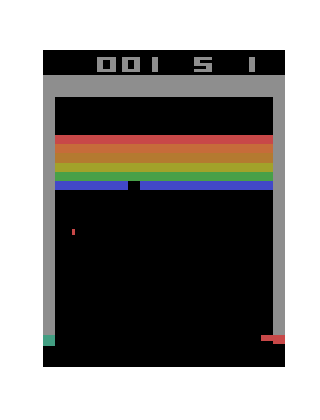
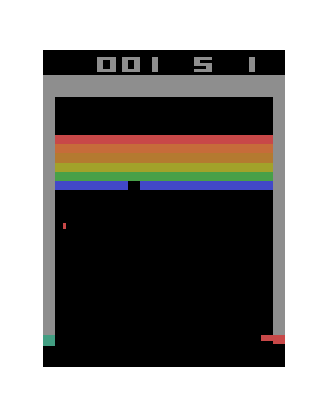
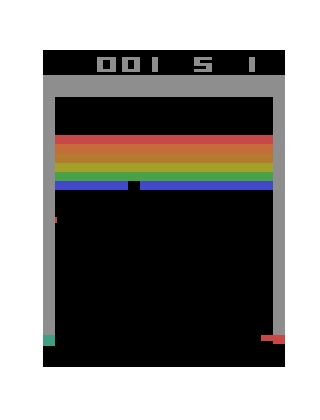
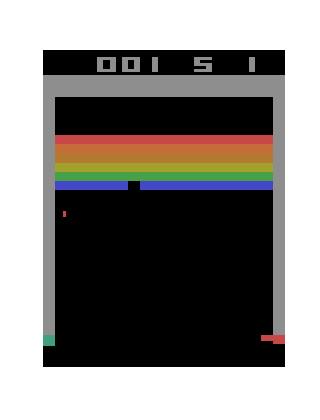
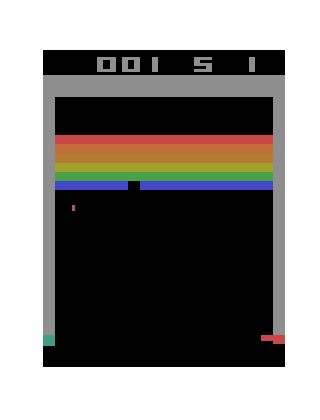
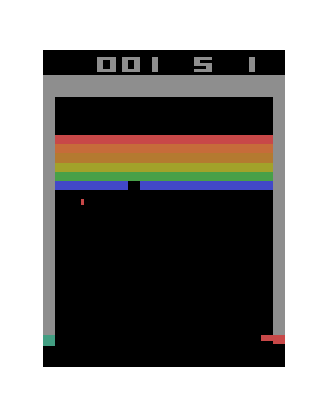
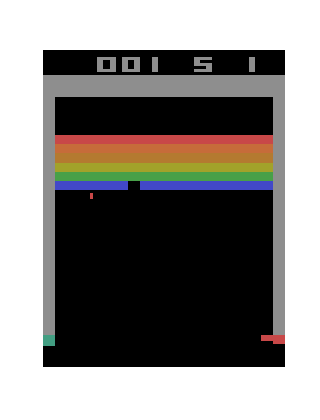
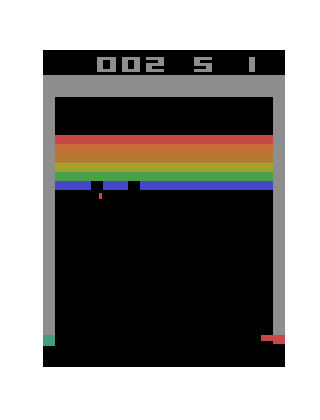
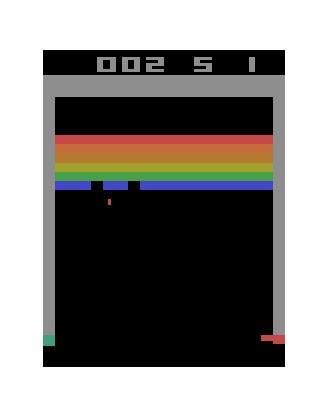
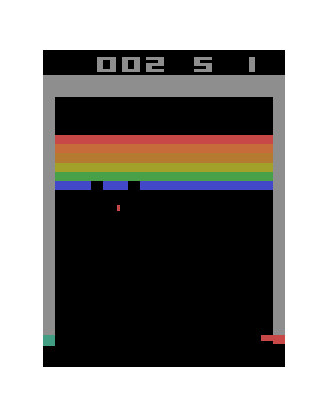
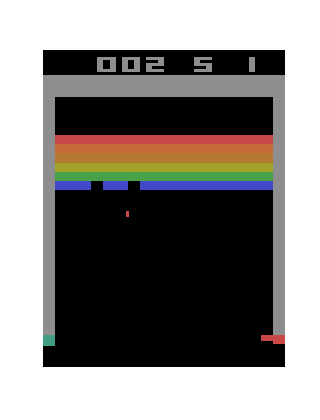
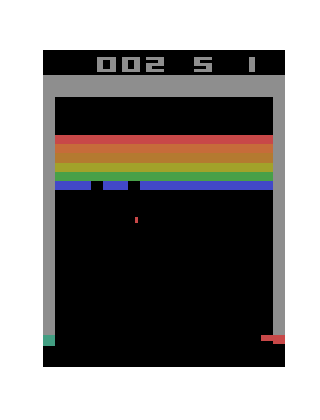
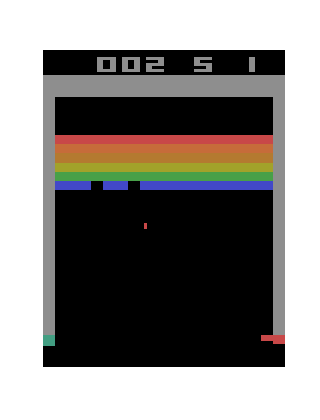
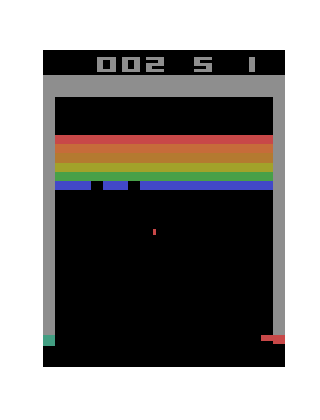
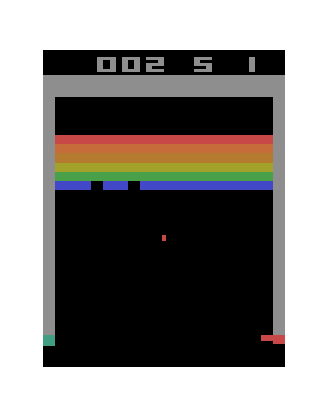
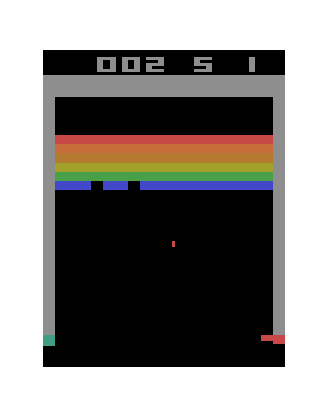
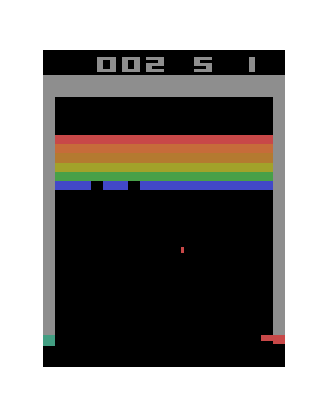
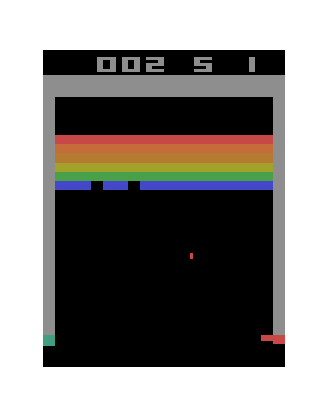
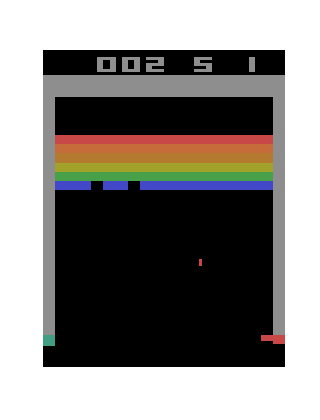
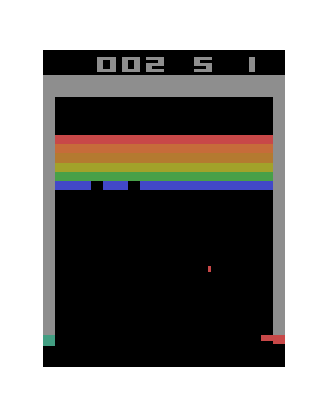
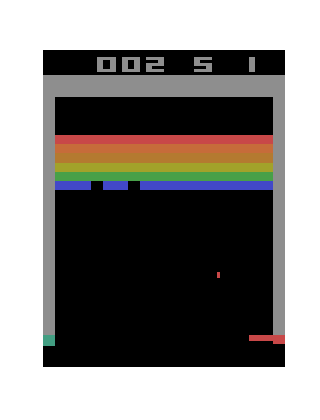
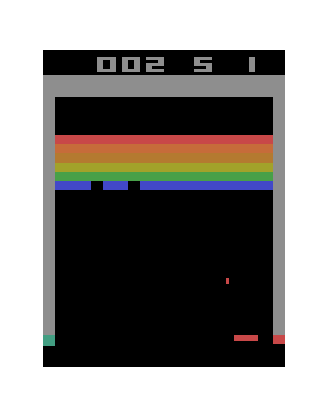
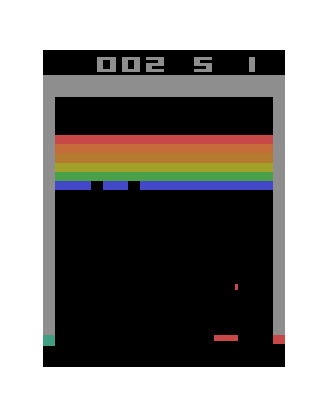
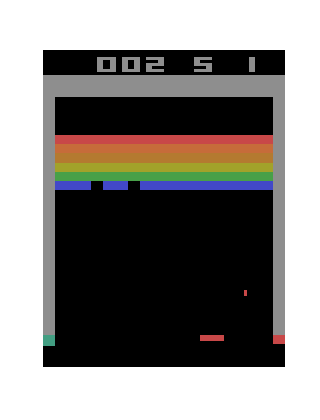
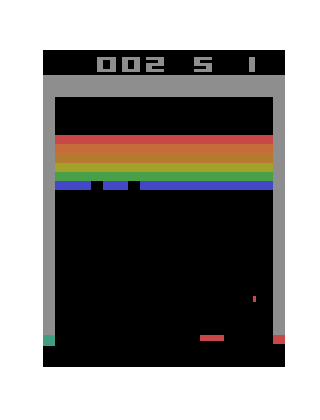
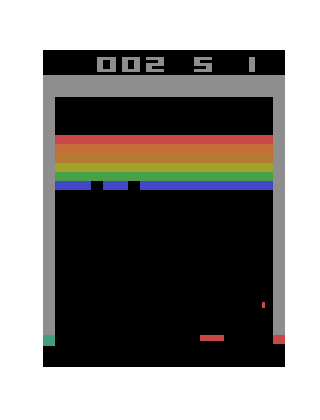
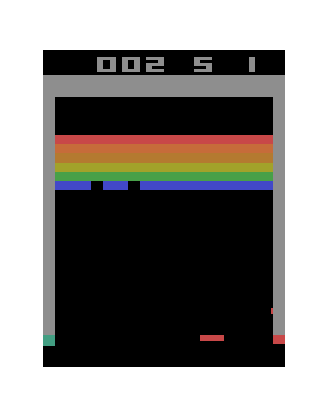
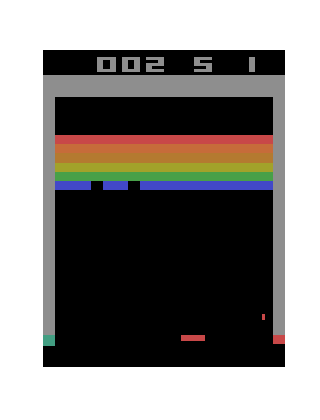
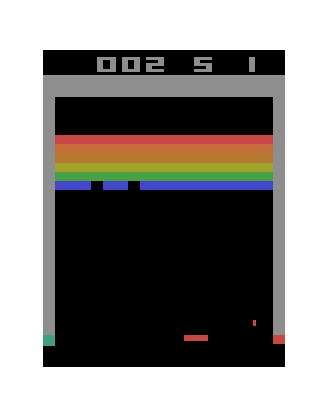
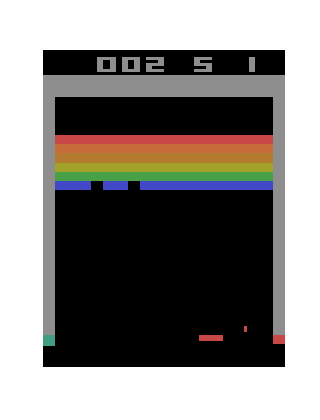
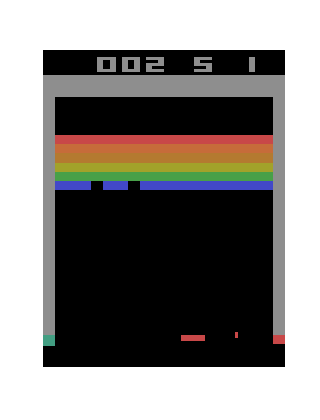
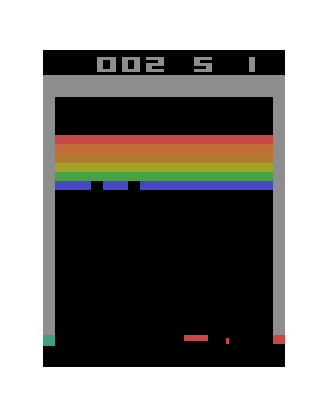
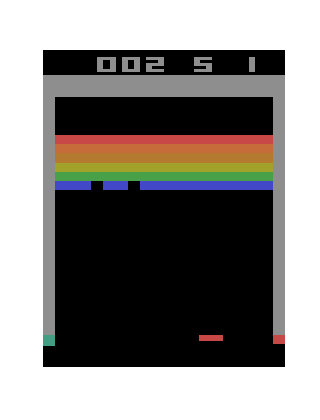
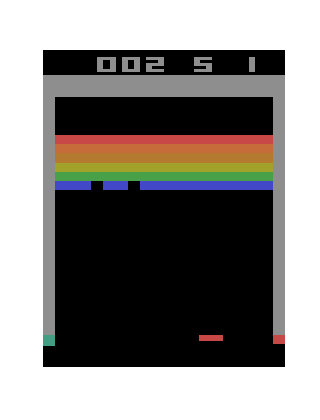
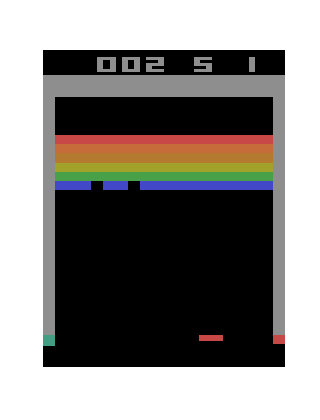
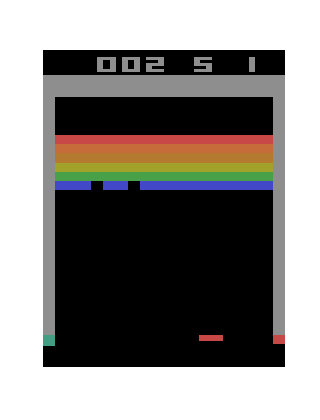
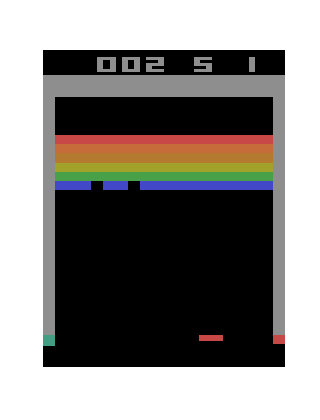
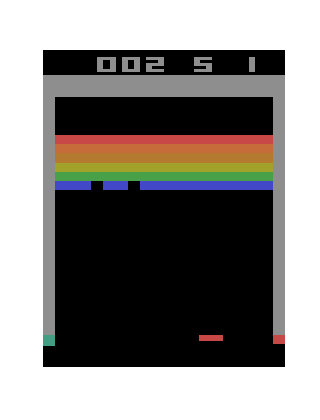
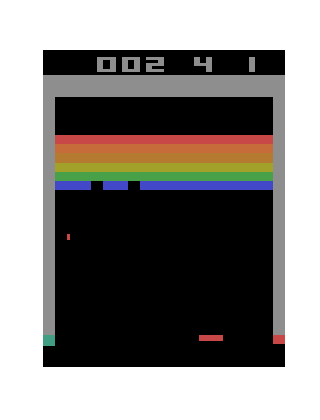

In [4]:
print('reward of one episode is', agent.test(test_step=None))
print('length of animationb: ', len(env.animation))
env.animation.run()
q_network.save("ddqn_breakout.h5")